Epoch 001 | train_loss=0.9959 f1=0.5947 | val_loss=2.2681 f1=0.3482
Epoch 002 | train_loss=0.6025 f1=0.7542 | val_loss=1.9944 f1=0.3551
Epoch 003 | train_loss=0.4914 f1=0.8009 | val_loss=2.7363 f1=0.3824
Epoch 004 | train_loss=0.4326 f1=0.8236 | val_loss=2.4149 f1=0.4607
Epoch 005 | train_loss=0.3945 f1=0.8401 | val_loss=2.7911 f1=0.4179
Epoch 006 | train_loss=0.3666 f1=0.8541 | val_loss=2.7077 f1=0.4403
Epoch 007 | train_loss=0.3473 f1=0.8626 | val_loss=2.9054 f1=0.4595
Epoch 008 | train_loss=0.3321 f1=0.8693 | val_loss=3.0975 f1=0.4942
Epoch 009 | train_loss=0.3120 f1=0.8764 | val_loss=2.9666 f1=0.4907
Epoch 010 | train_loss=0.2979 f1=0.8841 | val_loss=2.6953 f1=0.4996
Epoch 011 | train_loss=0.2872 f1=0.8889 | val_loss=2.3624 f1=0.5251
Epoch 012 | train_loss=0.2703 f1=0.8960 | val_loss=3.2046 f1=0.5444
Epoch 013 | train_loss=0.2663 f1=0.9001 | val_loss=3.7892 f1=0.4878
Epoch 014 | train_loss=0.2593 f1=0.9006 | val_loss=2.3624 f1=0.5433
Epoch 015 | train_loss=0.2535 f1=0.9045 | val_lo

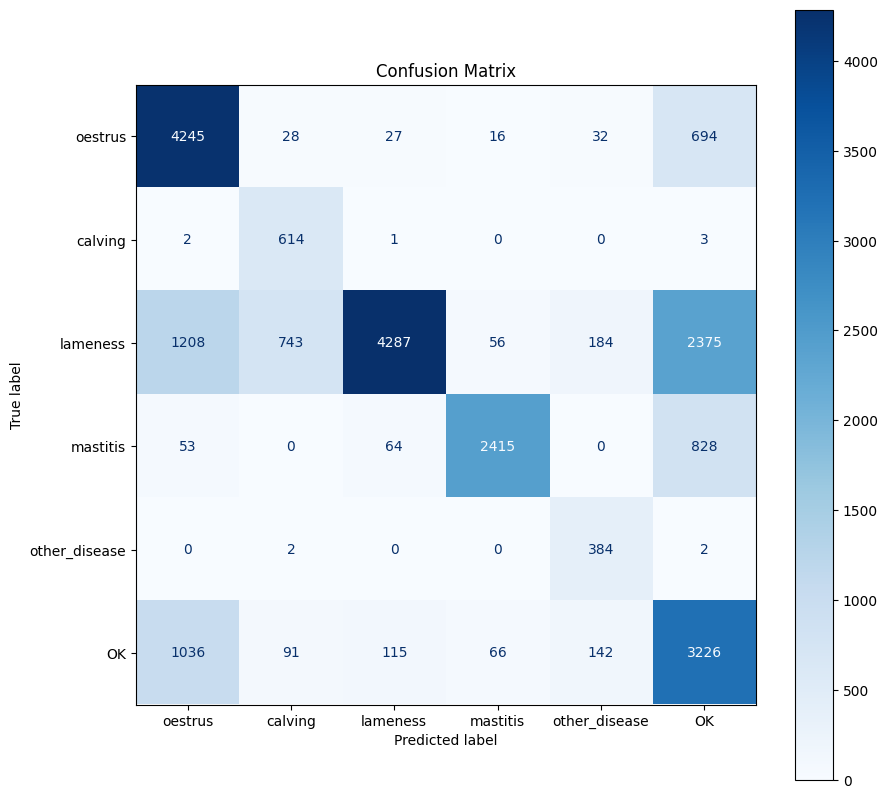


Test report:
               precision    recall  f1-score   support

      oestrus     0.8000    0.9440    0.8661      2000
      calving     0.9474    1.0000    0.9730      2072
     lameness     0.9761    0.7688    0.8602      2072
     mastitis     0.9801    0.9532    0.9665      2071
other_disease     0.9604    0.9990    0.9793      2063
           OK     0.7629    0.7368    0.7496      1782

     accuracy                         0.9039     12060
    macro avg     0.9045    0.9003    0.8991     12060
 weighted avg     0.9085    0.9039    0.9028     12060

Macro F1: 0.8991   Weighted F1: 0.9028


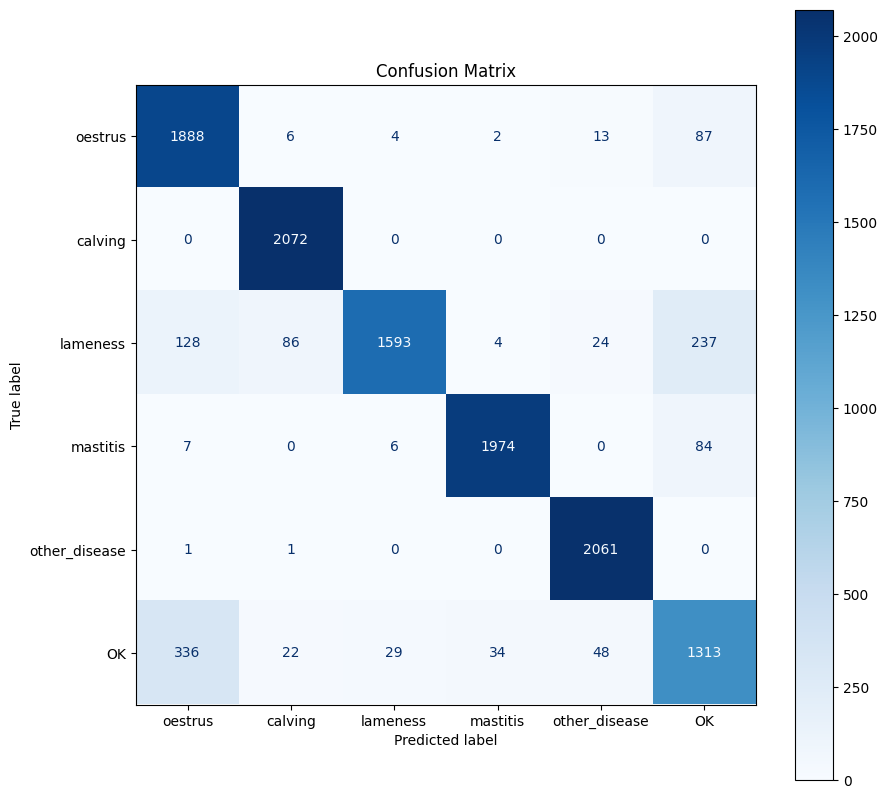

In [ ]:
# FT-Transformer for tabular/time-series (hand-crafted features)
# --------------------------------------------------------------
# - Works with continuous + categorical columns
# - Multiclass classification ready
# - Class weights, early stopping, and simple scheduler included

import math
import numpy as np
import pandas as pd
from typing import List, Dict, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ---------------------------
# Config
# ---------------------------
CFG = dict(
    d_token=192,             # token (embedding) dimension
    n_heads=8,               # attention heads (d_token % n_heads == 0)
    n_layers=4,              # transformer encoder layers
    attn_dropout=0.1,
    ff_dropout=0.2,          # feed-forward (MLP in the transformer) dropout
    token_dropout=0.1,       # Drop tokens (feature dropout) during training
    mlp_hidden=[256, 128],   # head MLP hidden dims
    mlp_dropout=0.2,
    lr=1e-3,
    weight_decay=1e-4,
    batch_size=256,
    epochs=40,
    early_stopping_patience=8,
    seed=42,
    num_workers=0,
    device="cuda" if torch.cuda.is_available() else "cpu",
)

# ---------------------------
# Utilities
# ---------------------------
def set_seed(seed: int):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

class TabularDataset(Dataset):
    """
    Expects:
      - df: pandas DataFrame with both train/val features already present
      - cont_cols: list of continuous feature col names
      - cat_cols: list of categorical feature col names (already integer-encoded 0..card-1)
      - label_col: column name with integer class ids [0..num_classes-1]
      - scaler: fitted StandardScaler for continuous features (optional during training; required for val/test)
    """
    def __init__(self, df: pd.DataFrame, cont_cols: List[str], cat_cols: List[str],
                 label_col: Optional[str] = None, scaler: Optional[StandardScaler] = None):
        self.df = df.reset_index(drop=True)
        self.cont_cols = cont_cols
        self.cat_cols = cat_cols
        self.label_col = label_col

        cont = df[cont_cols].astype(float).values if cont_cols else np.zeros((len(df), 0), dtype=np.float32)
        if scaler is not None and cont.shape[1] > 0:
            cont = scaler.transform(cont)
        self.cont = cont.astype(np.float32)

        if cat_cols:
            cats = []
            for c in cat_cols:
                # ensure integer type
                cats.append(df[c].astype(int).values)
            self.cats = np.stack(cats, axis=1).astype(np.int64)  # [N, n_cat]
        else:
            self.cats = np.zeros((len(df), 0), dtype=np.int64)

        if label_col is not None:
            self.y = df[label_col].astype(int).values
        else:
            self.y = None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x_cont = torch.from_numpy(self.cont[idx]) if self.cont.shape[1] > 0 else torch.zeros(0)
        x_cat = torch.from_numpy(self.cats[idx]) if self.cats.shape[1] > 0 else torch.zeros(0, dtype=torch.long)
        if self.y is not None:
            y = torch.tensor(self.y[idx], dtype=torch.long)
            return x_cont, x_cat, y
        return x_cont, x_cat

# ---------------------------
# FT-Transformer Components
# ---------------------------
class FeatureTokenizer(nn.Module):
    """
    Tokenizes features into a sequence of tokens:
      [CLS] + [cat_1, ..., cat_K] + [cont_1, ..., cont_M]
    - Each cat feature gets its own Embedding -> d_token
    - Each cont feature gets a linear projection -> d_token (with LayerNorm)
    """
    def __init__(self, n_cont: int, cat_cardinalities: List[int], d_token: int):
        super().__init__()
        self.n_cont = n_cont
        self.n_cat = len(cat_cardinalities)
        self.d_token = d_token

        # CLS token (learned)
        self.cls = nn.Parameter(torch.zeros(1, 1, d_token))
        nn.init.trunc_normal_(self.cls, std=0.02)

        # Cat embeddings
        self.cat_embeds = nn.ModuleList(
            [nn.Embedding(card, d_token) for card in cat_cardinalities]
        )
        for emb in self.cat_embeds:
            nn.init.trunc_normal_(emb.weight, std=0.02)

        # Continuous projection: one linear per feature (more expressive than single shared)
        self.cont_linears = nn.ModuleList([nn.Linear(1, d_token) for _ in range(n_cont)])
        self.cont_norm = nn.LayerNorm(d_token)

    def forward(self, x_cont: torch.Tensor, x_cat: torch.Tensor) -> torch.Tensor:
        """
        x_cont: [B, n_cont] float
        x_cat : [B, n_cat] long
        returns: tokens [B, 1 + n_cat + n_cont, d_token]
        """
        B = x_cont.size(0) if x_cont.ndim == 2 else x_cat.size(0)
        tokens = []

        # CLS
        cls_tok = self.cls.expand(B, -1, -1)  # [B, 1, d]
        tokens.append(cls_tok)

        # Cat tokens
        if self.n_cat > 0:
            cat_tokens = []
            for i, emb in enumerate(self.cat_embeds):
                cat_tokens.append(emb(x_cat[:, i]))  # [B, d]
            cat_tokens = torch.stack(cat_tokens, dim=1)  # [B, n_cat, d]
            tokens.append(cat_tokens)

        # Cont tokens
        if self.n_cont > 0:
            cont_tokens = []
            for i, lin in enumerate(self.cont_linears):
                v = lin(x_cont[:, i:i+1])  # [B, d]
                v = self.cont_norm(v)
                cont_tokens.append(v)
            cont_tokens = torch.stack(cont_tokens, dim=1)  # [B, n_cont, d]
            tokens.append(cont_tokens)

        return torch.cat(tokens, dim=1)  # [B, L, d]

class TokenDropout(nn.Module):
    """Feature (token) dropout: randomly drop non-CLS tokens during training."""
    def __init__(self, p: float):
        super().__init__()
        self.p = p

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if not self.training or self.p <= 0.0:
            return x
        B, L, D = x.shape
        # keep CLS (index 0)
        mask = torch.ones(B, L, device=x.device, dtype=torch.bool)
        drop = torch.rand(B, L-1, device=x.device) < self.p
        mask[:, 1:] = ~drop
        # To keep sequence length, zero-out dropped tokens (could also replace with learnable padding)
        x = x * mask.unsqueeze(-1)
        return x

class FTTransformer(nn.Module):
    def __init__(
        self,
        n_cont: int,
        cat_cardinalities: List[int],
        d_token: int,
        n_heads: int,
        n_layers: int,
        attn_dropout: float,
        ff_dropout: float,
        token_dropout: float,
        num_classes: int,
        mlp_hidden: List[int],
        mlp_dropout: float,
    ):
        super().__init__()
        self.tokenizer = FeatureTokenizer(n_cont, cat_cardinalities, d_token)
        self.token_dropout = TokenDropout(token_dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token,
            nhead=n_heads,
            dim_feedforward=d_token * 4,
            dropout=ff_dropout,
            batch_first=True,
            activation="gelu",
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Head on CLS token
        head_layers = []
        in_dim = d_token
        for h in mlp_hidden:
            head_layers += [nn.Linear(in_dim, h), nn.ReLU(), nn.Dropout(mlp_dropout)]
            in_dim = h
        head_layers += [nn.Linear(in_dim, num_classes)]
        self.head = nn.Sequential(*head_layers)

        # Xavier init for head
        for m in self.head:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x_cont: torch.Tensor, x_cat: torch.Tensor) -> torch.Tensor:
        # Tokens: [B, L, d]
        x = self.tokenizer(x_cont, x_cat)
        x = self.token_dropout(x)
        x = self.encoder(x)               # [B, L, d]
        cls = x[:, 0, :]                  # [B, d]
        logits = self.head(cls)           # [B, C]
        return logits

# ---------------------------
# Training / Evaluation
# ---------------------------
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    all_pred, all_true = [], []
    for x_cont, x_cat, y in loader:
        x_cont = x_cont.to(device)
        x_cat = x_cat.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x_cont, x_cat)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * y.size(0)
        all_pred.append(torch.argmax(logits, dim=1).detach().cpu())
        all_true.append(y.detach().cpu())

    y_true = torch.cat(all_true).numpy()
    y_pred = torch.cat(all_pred).numpy()
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return running_loss / len(loader.dataset), macro_f1

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_pred, all_true = [], []
    for x_cont, x_cat, y in loader:
        x_cont = x_cont.to(device)
        x_cat = x_cat.to(device)
        y = y.to(device)

        logits = model(x_cont, x_cat)
        loss = criterion(logits, y)
        running_loss += loss.item() * y.size(0)

        all_pred.append(torch.argmax(logits, dim=1).cpu())
        all_true.append(y.cpu())

    y_true = torch.cat(all_true).numpy()
    y_pred = torch.cat(all_pred).numpy()
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return running_loss / len(loader.dataset), macro_f1, (y_true, y_pred)

def fit(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    criterion,
    device,
    epochs,
    patience
):
    best_val_f1 = -1
    best_state = None
    patience_ctr = 0

    for epoch in range(1, epochs + 1):
        tr_loss, tr_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_f1, _ = evaluate(model, val_loader, criterion, device)
        if scheduler is not None:
            scheduler.step()

        print(f"Epoch {epoch:03d} | train_loss={tr_loss:.4f} f1={tr_f1:.4f} "
              f"| val_loss={val_loss:.4f} f1={val_f1:.4f}")

        # Early stopping on F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_ctr = 0
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model, best_val_f1

# ---------------------------
# Data Preparation
# ---------------------------
def build_loaders(
    df_train: pd.DataFrame,
    df_val: pd.DataFrame,
    cont_cols: List[str],
    cat_cols: List[str],
    label_col: str,
    batch_size: int,
    num_workers: int
):
    # Standardize continuous on train only
    scaler = StandardScaler()
    if cont_cols:
        scaler.fit(df_train[cont_cols].astype(float).values)

    ds_train = TabularDataset(df_train, cont_cols, cat_cols, label_col, scaler)
    ds_val   = TabularDataset(df_val,   cont_cols, cat_cols, label_col, scaler)

    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    val_loader   = DataLoader(ds_val, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=True)
    return train_loader, val_loader, scaler

def infer_cardinalities(df: pd.DataFrame, cat_cols: List[str]) -> List[int]:
    cards = []
    for c in cat_cols:
        cards.append(int(df[c].max()) + 1)  # assumes 0..max encoding
    return cards

def run_ft_transformer(
    df_train: pd.DataFrame,
    df_val: pd.DataFrame,
    cont_cols: List[str],
    cat_cols: List[str],
    label_col: str,
    num_classes: int,
    cfg: Dict = CFG
):
    set_seed(cfg["seed"])
    device = cfg["device"]

    # Dataloaders
    train_loader, val_loader, scaler = build_loaders(
        df_train, df_val, cont_cols, cat_cols, label_col,
        batch_size=cfg["batch_size"], num_workers=cfg["num_workers"]
    )

    # Cardinalities
    cat_cards = infer_cardinalities(df_train, cat_cols) if cat_cols else []

    # Model
    model = FTTransformer(
        n_cont=len(cont_cols),
        cat_cardinalities=cat_cards,
        d_token=cfg["d_token"],
        n_heads=cfg["n_heads"],
        n_layers=cfg["n_layers"],
        attn_dropout=cfg["attn_dropout"],
        ff_dropout=cfg["ff_dropout"],
        token_dropout=cfg["token_dropout"],
        num_classes=num_classes,
        mlp_hidden=cfg["mlp_hidden"],
        mlp_dropout=cfg["mlp_dropout"],
    ).to(device)

    # Class weights (optional but useful for imbalance)
    y_train = df_train[label_col].astype(int).values
    classes = np.unique(y_train)
    class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    # Map to full range [0..num_classes-1]
    cw_vec = np.ones(num_classes, dtype=np.float32)
    for i, c in enumerate(classes):
        cw_vec[c] = class_weights[i]
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(cw_vec, dtype=torch.float32, device=device))

    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg["epochs"])

    model, best_val_f1 = fit(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        criterion=criterion,
        device=device,
        epochs=cfg["epochs"],
        patience=cfg["early_stopping_patience"]
    )

    # Final val report
    _, _, (y_true, y_pred) = evaluate(model, val_loader, criterion, device)
    print("\nValidation classification report:")
    print(classification_report(y_true, y_pred, digits=4))

    return model, scaler

# ---------------------------
# Evaluation Helpers
# ---------------------------
def make_target_column(df, label_cols, target_col='target'):
    """Build multiclass int target from one-hot columns if not already present."""
    if target_col not in df.columns:
        labels_matrix = df[label_cols].astype(float).values
        df[target_col] = labels_matrix.argmax(axis=1)
    return df

@torch.no_grad()
def evaluate_loader(model, loader, label_names, device='cpu', title="Evaluation"):
    model.eval()

    all_probs, all_preds, all_true = [], [], []
    for batch in loader:
        # Expect (x_cont, x_cat, y). If you have no categorical features, your dataset may return (x_cont, y).
        if len(batch) == 3:
            x_cont, x_cat, y = batch
        else:
            x_cont, y = batch
            x_cat = None

        x_cont = x_cont.to(device)
        y = y.to(device)
        if x_cat is not None:
            x_cat = x_cat.to(device)

        logits = model(x_cont, x_cat) if x_cat is not None else model(x_cont)
        probs = torch.softmax(logits, dim=1)
        all_probs.append(probs.cpu().numpy())
        all_preds.append(probs.argmax(dim=1).cpu().numpy())
        all_true.append(y.cpu().numpy())

    all_probs = np.vstack(all_probs)
    all_preds = np.concatenate(all_preds)
    all_true  = np.concatenate(all_true)

    print(f"\n{title}:")
    print(classification_report(all_true, all_preds, target_names=label_names, digits=4))
    cm = confusion_matrix(all_true, all_preds)
    macro = f1_score(all_true, all_preds, average='macro')
    weighted = f1_score(all_true, all_preds, average='weighted')
    print(f"Macro F1: {macro:.4f}   Weighted F1: {weighted:.4f}")

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    return {"probs": all_probs, "preds": all_preds, "true": all_true, "confusion_matrix": cm}

# ---------------------------
# Main Execution
# ---------------------------
if __name__ == "__main__":
    # Load and prepare data
    from pathlib import Path
    from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit

    df = pd.read_csv(Path("augmented_dataset1_trainval.csv"))

    # Define label & drop columns
    label_cols = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']
    drop_cols  = ['cow', 'duration_hours']   # will be removed from feature set

    # Build a single multiclass target from the one-hot columns
    labels_matrix = df[label_cols].astype(float).values
    y_int = labels_matrix.argmax(axis=1)
    df['target'] = y_int

    # Train/Val split (grouped by cow if available)
    if 'cow' in df.columns:
        # Grouped split to prevent leakage across cows
        gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
        groups = df['cow']
        train_idx, val_idx = next(gss.split(df, y_int, groups))
    else:
        # Stratified split on labels
        sss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
        train_idx, val_idx = next(sss.split(df, y_int))

    df_train = df.iloc[train_idx].copy()
    df_val   = df.iloc[val_idx].copy()

    # Build feature lists
    # Remove labels & drop_cols from the feature space
    excluded = set(label_cols + drop_cols + ['target'])
    candidate_cols = [c for c in df.columns if c not in excluded]

    # Continuous columns = numeric dtypes
    cont_cols = [c for c in candidate_cols if np.issubdtype(df[c].dtype, np.number)]

    # Categorical columns (integer-encoded 0..card-1)
    cat_cols = []  # e.g., ['cow_id_enc', 'month_enc'] if present & integer-encoded

    # Sanity check
    assert len(cont_cols) + len(cat_cols) > 0, "No features found. Check your drop/feature lists."

    # Configure FT-Transformer
    CFG.update({
        "d_token": 192,
        "n_heads": 8,                 # must divide d_token
        "n_layers": 4,
        "attn_dropout": 0.10,
        "ff_dropout": 0.20,
        "token_dropout": 0.10,
        "mlp_hidden": [512, 256, 128],
        "mlp_dropout": 0.30,

        "batch_size": 128,
        "lr": 5e-4,
        "weight_decay": 1e-4,
        "epochs": 200,
        "early_stopping_patience": 15,
    })

    num_classes = len(label_cols)

    # Train the model
    model, scaler = run_ft_transformer(
        df_train=df_train,
        df_val=df_val,
        cont_cols=cont_cols,
        cat_cols=cat_cols,
        label_col='target',
        num_classes=num_classes,
        cfg=CFG
    )

    # Evaluate on validation set
    val_ds = TabularDataset(df_val, cont_cols, cat_cols, label_col='target', scaler=scaler)
    val_loader = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False)

    val_results = evaluate_loader(
        model=model,
        loader=val_loader,
        label_names=label_cols,
        device=CFG["device"],
        title="Validation report"
    )

    # Load and evaluate on test set
    df_test = pd.read_csv(Path("augmented_dataset1_holdout.csv"))
    df_test = make_target_column(df_test, label_cols, target_col='target')

    # Build test dataset with the SAME scaler learned on train
    test_ds = TabularDataset(df_test, cont_cols, cat_cols, label_col='target', scaler=scaler)
    test_loader = DataLoader(test_ds, batch_size=CFG["batch_size"], shuffle=False)

    # Evaluate on test set
    test_results = evaluate_loader(
        model=model,
        loader=test_loader,
        label_names=label_cols,
        device=CFG["device"],
        title="Test report"
    )

Epoch 001 | train_loss=0.9502 f1=0.3793 | val_loss=1.2446 f1=0.2739
Epoch 002 | train_loss=0.6525 f1=0.5369 | val_loss=1.3380 f1=0.3252
Epoch 003 | train_loss=0.4659 f1=0.6381 | val_loss=1.3314 f1=0.3661
Epoch 004 | train_loss=0.3432 f1=0.7038 | val_loss=1.3557 f1=0.4023
Epoch 005 | train_loss=0.2709 f1=0.7466 | val_loss=1.8030 f1=0.3940
Epoch 006 | train_loss=0.2290 f1=0.7673 | val_loss=1.5683 f1=0.4441
Epoch 007 | train_loss=0.2027 f1=0.7857 | val_loss=1.7920 f1=0.4171
Epoch 008 | train_loss=0.1862 f1=0.7980 | val_loss=1.8582 f1=0.4489
Epoch 009 | train_loss=0.1743 f1=0.8080 | val_loss=1.7672 f1=0.4483
Epoch 010 | train_loss=0.1693 f1=0.8147 | val_loss=2.2865 f1=0.4230
Epoch 011 | train_loss=0.1638 f1=0.8216 | val_loss=1.9376 f1=0.4495
Epoch 012 | train_loss=0.1599 f1=0.8242 | val_loss=1.6490 f1=0.4792
Epoch 013 | train_loss=0.1478 f1=0.8356 | val_loss=1.9954 f1=0.4704
Epoch 014 | train_loss=0.1444 f1=0.8379 | val_loss=1.6665 f1=0.5218
Epoch 015 | train_loss=0.1312 f1=0.8497 | val_lo

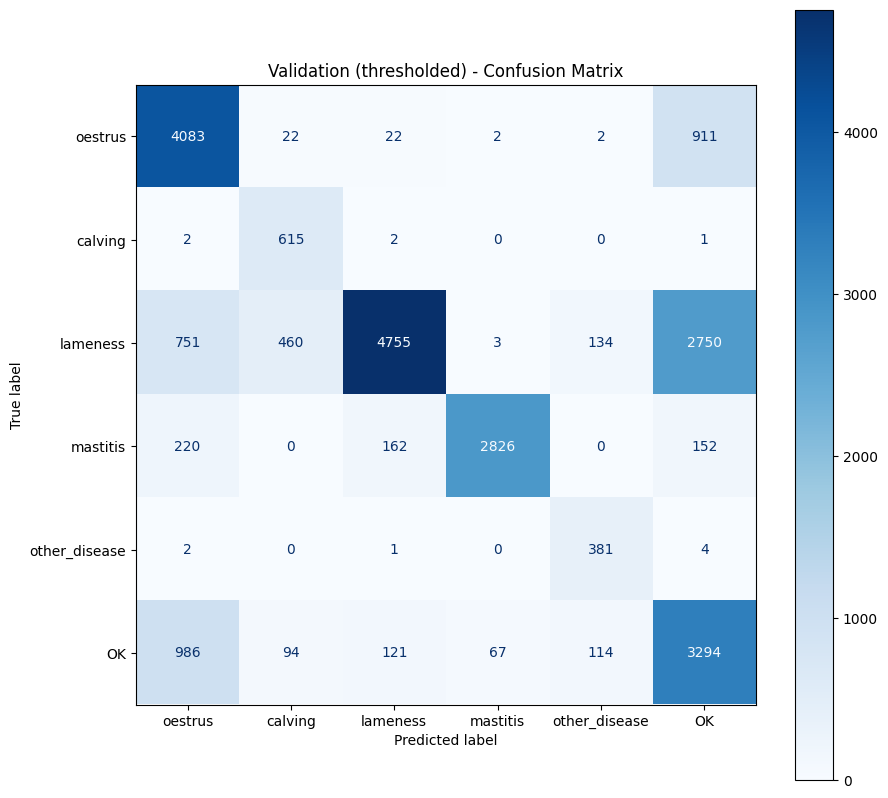


Test (argmax):
               precision    recall  f1-score   support

      oestrus     0.8285    0.9350    0.8786      2000
      calving     0.9597    1.0000    0.9794      2072
     lameness     0.9816    0.7471    0.8485      2072
     mastitis     0.9886    0.9638    0.9760      2071
other_disease     0.9722    0.9995    0.9857      2063
           OK     0.7312    0.7907    0.7598      1782

     accuracy                         0.9085     12060
    macro avg     0.9103    0.9060    0.9047     12060
 weighted avg     0.9150    0.9085    0.9082     12060

Macro F1: 0.9047   Weighted F1: 0.9082


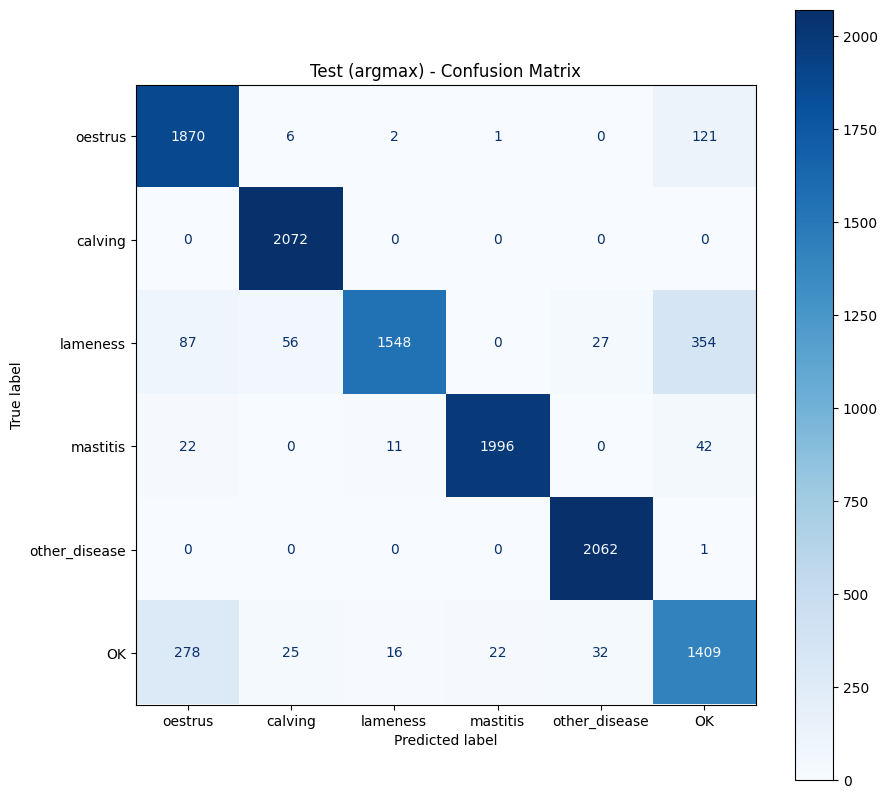


Test (thresholded):
               precision    recall  f1-score   support

      oestrus     0.8289    0.9350    0.8788      2000
      calving     0.9597    0.9990    0.9790      2072
     lameness     0.9652    0.7775    0.8613      2072
     mastitis     0.9810    0.9720    0.9765      2071
other_disease     0.9740    0.9990    0.9864      2063
           OK     0.7624    0.7744    0.7684      1782

     accuracy                         0.9125     12060
    macro avg     0.9119    0.9095    0.9084     12060
 weighted avg     0.9159    0.9125    0.9118     12060

Macro F1: 0.9084   Weighted F1: 0.9118


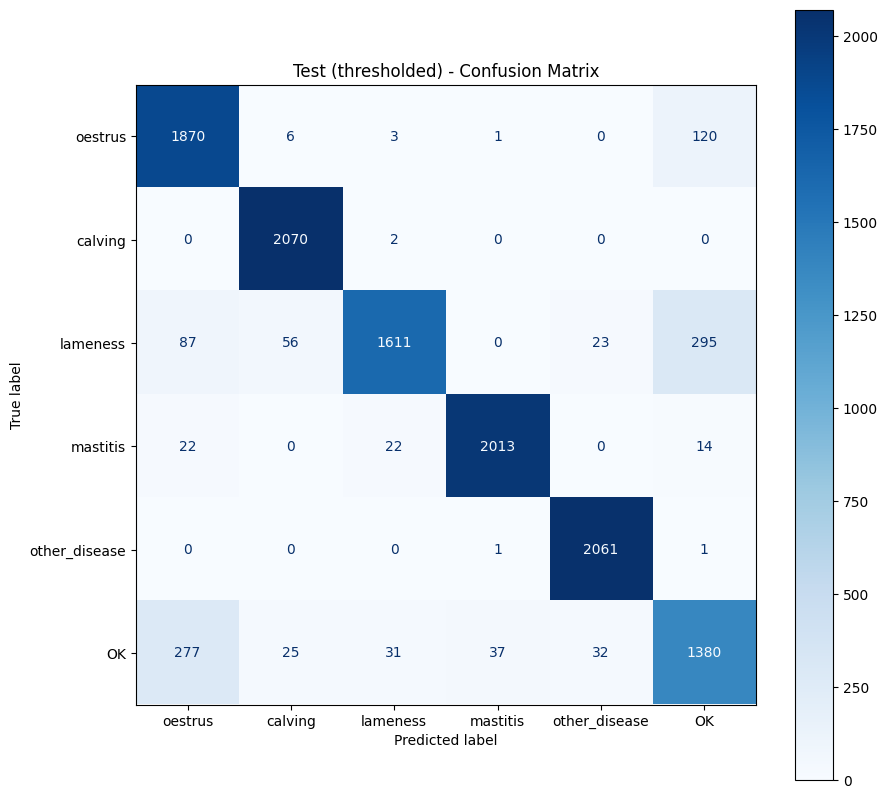

In [ ]:
# FT-Transformer for tabular/time-series (hand-crafted features) — Enhanced
# -------------------------------------------------------------------------
# - Focal Loss with class-balanced weights
# - WeightedRandomSampler for balanced mini-batches
# - OneCycleLR with warmup (per-batch stepping)
# - Per-class threshold tuning on validation for macro-F1 improvements
# - Grouped split by 'cow' to avoid leakage
# - Confusion matrix + full reports for val & test (with thresholds)

import math
import numpy as np
import pandas as pd
from typing import List, Dict, Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# ---------------------------
# Config
# ---------------------------
CFG = dict(
    d_token=192,             # token (embedding) dimension
    n_heads=8,               # attention heads (d_token % n_heads == 0)
    n_layers=4,              # transformer encoder layers
    attn_dropout=0.1,
    ff_dropout=0.2,          # feed-forward (MLP in the transformer) dropout
    token_dropout=0.1,       # Drop tokens (feature dropout) during training
    mlp_hidden=[256, 128],   # head MLP hidden dims
    mlp_dropout=0.2,
    lr=1e-3,
    weight_decay=1e-4,
    batch_size=256,
    epochs=40,
    early_stopping_patience=8,
    seed=42,
    num_workers=0,
    device="cuda" if torch.cuda.is_available() else "cpu",
)


# ---------------------------
# Utilities
# ---------------------------
def set_seed(seed: int):
    import random, os
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)


class TabularDataset(Dataset):
    """
    Expects:
      - df: pandas DataFrame with both train/val features already present
      - cont_cols: list of continuous feature col names
      - cat_cols: list of categorical feature col names (already integer-encoded 0..card-1)
      - label_col: column name with integer class ids [0..num_classes-1]
      - scaler: fitted StandardScaler for continuous features (optional during training; required for val/test)
    """
    def __init__(self, df: pd.DataFrame, cont_cols: List[str], cat_cols: List[str],
                 label_col: Optional[str] = None, scaler: Optional[StandardScaler] = None):
        self.df = df.reset_index(drop=True)
        self.cont_cols = cont_cols
        self.cat_cols = cat_cols
        self.label_col = label_col

        cont = df[cont_cols].astype(float).values if cont_cols else np.zeros((len(df), 0), dtype=np.float32)
        if scaler is not None and cont.shape[1] > 0:
            cont = scaler.transform(cont)
        self.cont = cont.astype(np.float32)

        if cat_cols:
            cats = []
            for c in cat_cols:
                # ensure integer type
                cats.append(df[c].astype(int).values)
            self.cats = np.stack(cats, axis=1).astype(np.int64)  # [N, n_cat]
        else:
            self.cats = np.zeros((len(df), 0), dtype=np.int64)

        if label_col is not None:
            self.y = df[label_col].astype(int).values
        else:
            self.y = None

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        x_cont = torch.from_numpy(self.cont[idx]) if self.cont.shape[1] > 0 else torch.zeros(0)
        x_cat = torch.from_numpy(self.cats[idx]) if self.cats.shape[1] > 0 else torch.zeros(0, dtype=torch.long)
        if self.y is not None:
            y = torch.tensor(self.y[idx], dtype=torch.long)
            return x_cont, x_cat, y
        return x_cont, x_cat


# ---------------------------
# FT-Transformer Components
# ---------------------------
class FeatureTokenizer(nn.Module):
    """
    Tokenizes features into a sequence of tokens:
      [CLS] + [cat_1, ..., cat_K] + [cont_1, ..., cont_M]
    - Each cat feature gets its own Embedding -> d_token
    - Each cont feature gets a linear projection -> d_token (with LayerNorm)
    """
    def __init__(self, n_cont: int, cat_cardinalities: List[int], d_token: int):
        super().__init__()
        self.n_cont = n_cont
        self.n_cat = len(cat_cardinalities)
        self.d_token = d_token

        # CLS token (learned)
        self.cls = nn.Parameter(torch.zeros(1, 1, d_token))
        nn.init.trunc_normal_(self.cls, std=0.02)

        # Cat embeddings
        self.cat_embeds = nn.ModuleList(
            [nn.Embedding(card, d_token) for card in cat_cardinalities]
        )
        for emb in self.cat_embeds:
            nn.init.trunc_normal_(emb.weight, std=0.02)

        # Continuous projection: one linear per feature (more expressive than single shared)
        self.cont_linears = nn.ModuleList([nn.Linear(1, d_token) for _ in range(n_cont)])
        self.cont_norm = nn.LayerNorm(d_token)

    def forward(self, x_cont: torch.Tensor, x_cat: torch.Tensor) -> torch.Tensor:
        """
        x_cont: [B, n_cont] float
        x_cat : [B, n_cat] long
        returns: tokens [B, 1 + n_cat + n_cont, d_token]
        """
        B = x_cont.size(0) if x_cont.ndim == 2 else x_cat.size(0)
        tokens = []

        # CLS
        cls_tok = self.cls.expand(B, -1, -1)  # [B, 1, d]
        tokens.append(cls_tok)

        # Cat tokens
        if self.n_cat > 0:
            cat_tokens = []
            for i, emb in enumerate(self.cat_embeds):
                cat_tokens.append(emb(x_cat[:, i]))  # [B, d]
            cat_tokens = torch.stack(cat_tokens, dim=1)  # [B, n_cat, d]
            tokens.append(cat_tokens)

        # Cont tokens
        if self.n_cont > 0:
            cont_tokens = []
            for i, lin in enumerate(self.cont_linears):
                v = lin(x_cont[:, i:i+1])  # [B, d]
                v = self.cont_norm(v)
                cont_tokens.append(v)
            cont_tokens = torch.stack(cont_tokens, dim=1)  # [B, n_cont, d]
            tokens.append(cont_tokens)

        return torch.cat(tokens, dim=1)  # [B, L, d]


class TokenDropout(nn.Module):
    """Feature (token) dropout: randomly drop non-CLS tokens during training."""
    def __init__(self, p: float):
        super().__init__()
        self.p = p

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if not self.training or self.p <= 0.0:
            return x
        B, L, D = x.shape
        # keep CLS (index 0)
        mask = torch.ones(B, L, device=x.device, dtype=torch.bool)
        drop = torch.rand(B, L-1, device=x.device) < self.p
        mask[:, 1:] = ~drop
        # zero-out dropped tokens (keep length)
        x = x * mask.unsqueeze(-1)
        return x


class FTTransformer(nn.Module):
    def __init__(
        self,
        n_cont: int,
        cat_cardinalities: List[int],
        d_token: int,
        n_heads: int,
        n_layers: int,
        attn_dropout: float,
        ff_dropout: float,
        token_dropout: float,
        num_classes: int,
        mlp_hidden: List[int],
        mlp_dropout: float,
    ):
        super().__init__()
        self.tokenizer = FeatureTokenizer(n_cont, cat_cardinalities, d_token)
        self.token_dropout = TokenDropout(token_dropout)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_token,
            nhead=n_heads,
            dim_feedforward=d_token * 4,
            dropout=ff_dropout,
            batch_first=True,
            activation="gelu",
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Head on CLS token
        head_layers = []
        in_dim = d_token
        for h in mlp_hidden:
            head_layers += [nn.Linear(in_dim, h), nn.ReLU(), nn.Dropout(mlp_dropout)]
            in_dim = h
        head_layers += [nn.Linear(in_dim, num_classes)]
        self.head = nn.Sequential(*head_layers)

        # Xavier init for head
        for m in self.head:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x_cont: torch.Tensor, x_cat: torch.Tensor) -> torch.Tensor:
        # Tokens: [B, L, d]
        x = self.tokenizer(x_cont, x_cat)
        x = self.token_dropout(x)
        x = self.encoder(x)               # [B, L, d]
        cls = x[:, 0, :]                  # [B, d]
        logits = self.head(cls)           # [B, C]
        return logits


# ---------------------------
# Loss (Focal with class-balanced alpha)
# ---------------------------
class FocalLoss(nn.Module):
    def __init__(self, alpha: torch.Tensor, gamma: float = 2.0, reduction: str = "mean"):
        super().__init__()
        self.alpha = alpha  # shape [C] on device
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, target):
        logp = F.log_softmax(logits, dim=1)              # [B,C]
        p = logp.exp()
        ce = F.nll_loss(logp, target, reduction="none")  # [B]
        pt = p[torch.arange(target.size(0)), target]     # [B]
        at = self.alpha[target]                          # [B]
        loss = at * ((1 - pt) ** self.gamma) * ce
        return loss.mean() if self.reduction == "mean" else loss.sum()


# ---------------------------
# Training / Evaluation
# ---------------------------
def train_one_epoch(model, loader, optimizer, criterion, device, scheduler=None):
    model.train()
    running_loss = 0.0
    all_pred, all_true = [], []
    for x_cont, x_cat, y in loader:
        x_cont = x_cont.to(device)
        x_cat = x_cat.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x_cont, x_cat)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()  # per-batch step (OneCycleLR)

        running_loss += loss.item() * y.size(0)
        all_pred.append(torch.argmax(logits, dim=1).detach().cpu())
        all_true.append(y.detach().cpu())

    y_true = torch.cat(all_true).numpy()
    y_pred = torch.cat(all_pred).numpy()
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return running_loss / len(loader.dataset), macro_f1


@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_logits, all_true = [], []
    for x_cont, x_cat, y in loader:
        x_cont = x_cont.to(device)
        x_cat = x_cat.to(device)
        y = y.to(device)

        logits = model(x_cont, x_cat)
        loss = criterion(logits, y)
        running_loss += loss.item() * y.size(0)

        all_logits.append(logits.cpu())
        all_true.append(y.cpu())

    logits = torch.cat(all_logits, dim=0)
    y_true = torch.cat(all_true).numpy()
    y_pred = logits.argmax(dim=1).numpy()
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    return running_loss / len(loader.dataset), macro_f1, (y_true, y_pred), logits.numpy()


def fit(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    criterion,
    device,
    epochs,
    patience
):
    best_val_f1 = -1
    best_state = None
    patience_ctr = 0

    for epoch in range(1, epochs + 1):
        tr_loss, tr_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device, scheduler=scheduler)
        val_loss, val_f1, _, _ = evaluate(model, val_loader, criterion, device)

        print(f"Epoch {epoch:03d} | train_loss={tr_loss:.4f} f1={tr_f1:.4f} "
              f"| val_loss={val_loss:.4f} f1={val_f1:.4f}")

        # Early stopping on F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_ctr = 0
        else:
            patience_ctr += 1
            if patience_ctr >= patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
    return model, best_val_f1


# ---------------------------
# Data Preparation
# ---------------------------
def build_scaler(df_train: pd.DataFrame, cont_cols: List[str]) -> Optional[StandardScaler]:
    scaler = StandardScaler()
    if cont_cols:
        scaler.fit(df_train[cont_cols].astype(float).values)
    return scaler


def infer_cardinalities(df: pd.DataFrame, cat_cols: List[str]) -> List[int]:
    cards = []
    for c in cat_cols:
        cards.append(int(df[c].max()) + 1)  # assumes 0..max encoding
    return cards


def make_target_column(df, label_cols, target_col='target'):
    if target_col not in df.columns:
        labels_matrix = df[label_cols].astype(float).values
        df[target_col] = labels_matrix.argmax(axis=1)
    return df


# ---------------------------
# Threshold tuning helpers
# ---------------------------
def find_opt_thresholds(probs: np.ndarray, y_true: np.ndarray, search=np.linspace(0.2, 0.9, 36)) -> np.ndarray:
    C = probs.shape[1]
    best = np.zeros(C)
    for c in range(C):
        best_f1, best_t = -1.0, 0.5
        for t in search:
            pred_c = (probs[:, c] >= t).astype(int)
            y_c = (y_true == c).astype(int)
            f1 = f1_score(y_c, pred_c, zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        best[c] = best_t
    return best


@torch.no_grad()
def collect_probs_and_true(model, loader, device):
    model.eval()
    P, Y = [], []
    for x_cont, x_cat, y in loader:
        x_cont, x_cat = x_cont.to(device), x_cat.to(device)
        logits = model(x_cont, x_cat)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        P.append(probs)
        Y.append(y.numpy())
    return np.vstack(P), np.concatenate(Y)


def predict_with_thresholds(model, loader, thresholds, device):
    probs, y_true = collect_probs_and_true(model, loader, device)
    adj = (probs >= thresholds.reshape(1, -1)).astype(int)
    preds = np.where(adj.sum(1) > 0, adj.argmax(1), probs.argmax(1))
    return preds, y_true, probs


def evaluate_with_cm(y_true, y_pred, labels_names, title):
    print(f"\n{title}:")
    print(classification_report(y_true, y_pred, target_names=labels_names, digits=4))
    print(f"Macro F1: {f1_score(y_true, y_pred, average='macro'):.4f}   "
          f"Weighted F1: {f1_score(y_true, y_pred, average='weighted'):.4f}")
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_names)
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title(f"{title} - Confusion Matrix")
    plt.show()


# ---------------------------
# Training wrapper
# ---------------------------
def run_ft_transformer(
    df_train: pd.DataFrame,
    df_val: pd.DataFrame,
    cont_cols: List[str],
    cat_cols: List[str],
    label_col: str,
    num_classes: int,
    cfg: Dict = CFG
):
    set_seed(cfg["seed"])
    device = cfg["device"]

    # Scaler
    scaler = build_scaler(df_train, cont_cols)

    # Datasets
    ds_train = TabularDataset(df_train, cont_cols, cat_cols, label_col, scaler)
    ds_val   = TabularDataset(df_val,   cont_cols, cat_cols, label_col, scaler)

    # Cardinalities
    cat_cards = infer_cardinalities(df_train, cat_cols) if cat_cols else []

    # Model
    model = FTTransformer(
        n_cont=len(cont_cols),
        cat_cardinalities=cat_cards,
        d_token=cfg["d_token"],
        n_heads=cfg["n_heads"],
        n_layers=cfg["n_layers"],
        attn_dropout=cfg["attn_dropout"],
        ff_dropout=cfg["ff_dropout"],
        token_dropout=cfg["token_dropout"],
        num_classes=num_classes,
        mlp_hidden=cfg["mlp_hidden"],
        mlp_dropout=cfg["mlp_dropout"],
    ).to(device)

    # Focal loss with effective-number alpha
    y_train = df_train[label_col].astype(int).values
    classes = np.arange(num_classes)
    class_counts = np.array([(y_train == c).sum() for c in classes])
    beta = 0.999
    eff_num = 1.0 - np.power(beta, class_counts)
    alpha = (1.0 - beta) / eff_num
    alpha = alpha / alpha.sum() * num_classes
    alpha_t = torch.tensor(alpha, dtype=torch.float32, device=device)
    criterion = FocalLoss(alpha=alpha_t, gamma=2.0)

    # Balanced sampler
    class_weights_for_sampler = 1.0 / (class_counts + 1e-9)
    sample_weights = class_weights_for_sampler[y_train]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # Dataloaders
    train_loader = DataLoader(ds_train, batch_size=cfg["batch_size"], sampler=sampler,
                              num_workers=cfg["num_workers"], pin_memory=True)
    val_loader   = DataLoader(ds_val, batch_size=cfg["batch_size"], shuffle=False,
                              num_workers=cfg["num_workers"], pin_memory=True)

    # Optim & OneCycleLR (per-batch stepping)
    optimizer = torch.optim.AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])
    steps_per_epoch = math.ceil(len(ds_train) / cfg["batch_size"])
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=cfg["lr"],
        steps_per_epoch=steps_per_epoch,
        epochs=cfg["epochs"],
        pct_start=0.1,
        div_factor=10,
        final_div_factor=10
    )

    # Train
    model, best_val_f1 = fit(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        criterion=criterion,
        device=device,
        epochs=cfg["epochs"],
        patience=cfg["early_stopping_patience"]
    )

    # Final val report (argmax)
    _, _, (y_true, y_pred), _ = evaluate(model, val_loader, criterion, device)
    print("\nValidation classification report (argmax):")
    print(classification_report(y_true, y_pred, digits=4))

    return model, scaler


# ---------------------------
# Main Execution
# ---------------------------
if __name__ == "__main__":
    # Load and prepare data
    from pathlib import Path
    from sklearn.model_selection import GroupShuffleSplit, StratifiedShuffleSplit

    df = pd.read_csv(Path("augmented_dataset1_trainval.csv"))

    # Define label & drop columns
    label_cols = ['oestrus', 'calving', 'lameness', 'mastitis', 'other_disease', 'OK']
    drop_cols  = ['cow', 'duration_hours']   # will be removed from feature set

    # Build a single multiclass target from the one-hot columns
    labels_matrix = df[label_cols].astype(float).values
    y_int = labels_matrix.argmax(axis=1)
    df['target'] = y_int

    # Train/Val split (grouped by cow if available)
    if 'cow' in df.columns:
        # Grouped split to prevent leakage across cows
        gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
        groups = df['cow']
        train_idx, val_idx = next(gss.split(df, y_int, groups))
    else:
        # Stratified split on labels
        sss = StratifiedShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
        train_idx, val_idx = next(sss.split(df, y_int))

    df_train = df.iloc[train_idx].copy()
    df_val   = df.iloc[val_idx].copy()

    # Build feature lists
    # Remove labels & drop_cols from the feature space
    excluded = set(label_cols + drop_cols + ['target'])
    candidate_cols = [c for c in df.columns if c not in excluded]

    # Continuous columns = numeric dtypes
    cont_cols = [c for c in candidate_cols if np.issubdtype(df[c].dtype, np.number)]

    # Categorical columns (integer-encoded 0..card-1)
    cat_cols = []  # e.g., ['cow_id_enc', 'month_enc'] if present & integer-encoded

    # Sanity check
    assert len(cont_cols) + len(cat_cols) > 0, "No features found. Check your drop/feature lists."

    # Configure FT-Transformer
    CFG.update({
        "d_token": 192,
        "n_heads": 8,                 # must divide d_token
        "n_layers": 4,
        "attn_dropout": 0.10,
        "ff_dropout": 0.20,
        "token_dropout": 0.10,
        "mlp_hidden": [512, 256, 128],
        "mlp_dropout": 0.30,

        "batch_size": 128,
        "lr": 5e-4,
        "weight_decay": 1e-4,
        "epochs": 120,
        "early_stopping_patience": 20,
    })

    num_classes = len(label_cols)

    # Train the model
    model, scaler = run_ft_transformer(
        df_train=df_train,
        df_val=df_val,
        cont_cols=cont_cols,
        cat_cols=cat_cols,
        label_col='target',
        num_classes=num_classes,
        cfg=CFG
    )

    # Evaluate on validation set (threshold tuning)
    val_ds = TabularDataset(df_val, cont_cols, cat_cols, label_col='target', scaler=scaler)
    val_loader = DataLoader(val_ds, batch_size=CFG["batch_size"], shuffle=False)

    # Collect val probs & tune per-class thresholds
    val_probs, val_true = collect_probs_and_true(model, val_loader, CFG["device"])
    thresholds = find_opt_thresholds(val_probs, val_true, search=np.linspace(0.2, 0.9, 36))

    # Apply tuned thresholds on validation
    val_preds, val_true_chk, _ = predict_with_thresholds(model, val_loader, thresholds, CFG["device"])
    evaluate_with_cm(val_true_chk, val_preds, label_cols, title="Validation (thresholded)")

    # Load and evaluate on test set
    df_test = pd.read_csv(Path("augmented_dataset1_holdout.csv"))
    df_test = make_target_column(df_test, label_cols, target_col='target')

    # Build test dataset with the SAME scaler learned on train
    test_ds = TabularDataset(df_test, cont_cols, cat_cols, label_col='target', scaler=scaler)
    test_loader = DataLoader(test_ds, batch_size=CFG["batch_size"], shuffle=False)

    # Argmax baseline on test (optional)
    with torch.no_grad():
        all_logits = []
        all_true = []
        for x_cont, x_cat, y in test_loader:
            x_cont, x_cat = x_cont.to(CFG["device"]), x_cat.to(CFG["device"])
            logits = model(x_cont, x_cat)
            all_logits.append(logits.cpu())
            all_true.append(y)
        logits = torch.cat(all_logits).numpy()
        test_true = torch.cat(all_true).numpy()
        test_pred_argmax = logits.argmax(axis=1)

    evaluate_with_cm(test_true, test_pred_argmax, label_cols, title="Test (argmax)")

    # Thresholded predictions on test
    test_preds, test_true_chk, _ = predict_with_thresholds(model, test_loader, thresholds, CFG["device"])
    evaluate_with_cm(test_true_chk, test_preds, label_cols, title="Test (thresholded)")
